In [205]:
import json
from pathlib import Path

import faiss
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm

In [206]:
RANDOM_SEED = 42

### Dataset

In [207]:
dataset_path = Path('flowers')

image_paths = list(dataset_path.glob('*/*.jpg'))

In [208]:
dataset_df = pd.DataFrame({'image_path': image_paths})
dataset_df['label'] = dataset_df['image_path'].apply(lambda x: x.parent.stem)
dataset_df['label'] = dataset_df['label'].astype('category')

dataset_df.head()

,image_path,label
0,flowers/daisy/14167534527_781ceb1b7a_n.jpg,daisy
1,flowers/daisy/34718882165_68cdc9def9_n.jpg,daisy
2,flowers/daisy/5512287917_9f5d3f0f98_n.jpg,daisy
3,flowers/daisy/476857510_d2b30175de_n.jpg,daisy
4,flowers/daisy/521762040_f26f2e08dd.jpg,daisy


In [209]:
len(dataset_df)

4317

In [210]:
from sklearn.model_selection import train_test_split

# Оставим 2% изображений для тестирования поиска
X_train, X_test, y_train, y_test = train_test_split(dataset_df["image_path"], dataset_df["label"], test_size=0.02, random_state=RANDOM_SEED, shuffle=True, stratify=dataset_df["label"])

In [211]:
X_train.to_csv("train.csv", index=False)

In [212]:
X_test.to_csv("test.csv", index=False)

In [213]:
test_paths = X_test.to_list()
train_paths = X_train.to_list()

### DINOv2

In [214]:
transform_image = T.Compose([T.ToTensor(), T.Resize(244), T.CenterCrop(224), T.Normalize([0.5], [0.5])])

def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)
    transformed_img = transform_image(img)[:3].unsqueeze(0)
    return transformed_img

In [215]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Using cache found in /Users/sonya/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [228]:
def create_index(files: list) -> faiss.IndexFlatL2:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    index = faiss.index_factory(384, "Flat", faiss.METRIC_INNER_PRODUCT)

    all_embeddings = {}
    
    with torch.no_grad():
      for i, file in enumerate(tqdm(files)):
        embeddings = dinov2_vits14(load_image(file).to(device))

        embedding = embeddings[0].cpu().numpy()

        all_embeddings[str(file)] = np.array(embedding).reshape(1, -1).tolist()

        embedding = np.array(embedding).reshape(1, -1)
        embedding = np.float32(embedding)
        faiss.normalize_L2(embedding)

        index.add(embedding)

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    faiss.write_index(index, "data.bin")

    return index, all_embeddings

In [236]:
def search_index(index: faiss.IndexFlatL2, embeddings: np.ndarray, k: int = 5) -> tuple[np.ndarray, np.ndarray]:
    """
    Search the index for the images that are most similar to the provided image.
    
    Args:
        index: The FAISS index to search in
        embeddings: The embedding vectors to search for
        k: Number of similar images to return
        
    Returns:
        A tuple of (distances, indices) arrays for the k most similar images
    """
    embeddings = np.array(embeddings).reshape(1, -1)
    embeddings = np.float32(embeddings)
    faiss.normalize_L2(embeddings)
    D, I = index.search(embeddings, k)

    return I, D

In [230]:
def plot_search_results(indexes: list, scores: list, image_paths: list[Path], n: int = 5):
    """
    Plot the top n search results with their scores using matplotlib.
    
    Parameters:
    -----------
    indexes : list or numpy.ndarray
        Indexes of the top search results.
    scores : list or numpy.ndarray
        Similarity scores for the top search results.
    image_paths : list
        List of all image paths in the dataset.
    n : int, optional
        Number of results to display (default is 5).
    """


    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    
    if n == 1:
        axes = [axes]
    
    for i in range(n):
        idx = indexes[0][i]
        img_path = image_paths[idx]
        score = scores[0][i]
        
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Score: {score:.4f}\n{img_path.stem}\n{img_path.parent.stem}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [237]:
data_index, all_embeddings = create_index(train_paths[:100])

100%|██████████| 100/100 [00:03<00:00, 25.06it/s]


In [241]:
image_path = train_paths[0]
embedding = dinov2_vits14(load_image(image_path).to(device))
indices, scores  = search_index(data_index, embedding[0].cpu().detach().numpy().reshape(1, -1))

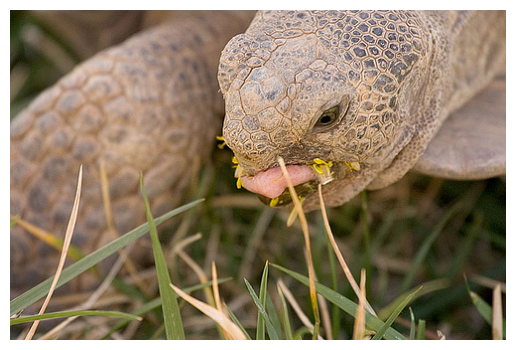

In [242]:
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

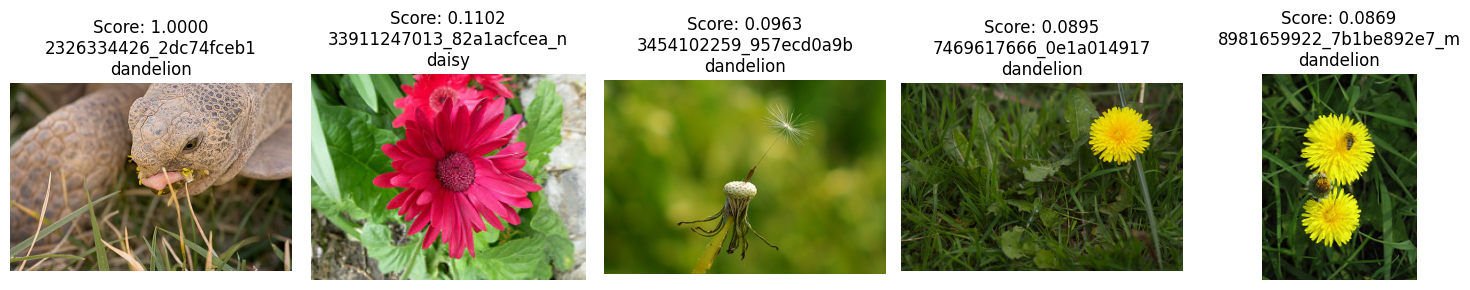

In [243]:
plot_search_results(indices, scores, train_paths, n=5)